In [3]:
import util
data = util.load_pickle_files('DATAA','ER')

Found the following pickle files:  ['2013 PROC 4.8.18.pkl', '2014 PROC 4.8.18.pkl', '2015 PROC 4.8.18.pkl', '2016 PROC 4.8.18.pkl', '2017 PROC 4.8.18.pkl', 'small_pickle.pkl']
Loading : 2013 PROC 4.8.18.pkl
Loading : 2014 PROC 4.8.18.pkl
Loading : 2015 PROC 4.8.18.pkl
Loading : 2016 PROC 4.8.18.pkl
Loading : 2017 PROC 4.8.18.pkl
Loading : small_pickle.pkl
Finished loading data
Total number of rows:  596673


Some initial stats

In [4]:
len(data)

596673

In [5]:
print(len(data.columns))
data.columns.tolist()

120


['Albumin -Blood',
 'Alkaline phosphatase -Blood',
 'Amylase -Blood',
 'Bilirubin -Blood, total',
 'CK-MB%',
 'CPK -Blood ,total',
 'CPK-MB',
 'CRP (Inflammatory)',
 'Calcium -Blood, total',
 'Chloride -Blood',
 'Cholesterol, total',
 'Creatinine -Blood',
 'EOS abs.',
 'Gamma GT -Blood',
 'Glucose -Blood',
 'HCO3',
 'HDL-Cholesterol, direct',
 'HGB',
 'HbA1C %',
 'INR',
 'LDH -Blood',
 'LDL Cholesterol, direct',
 'LYMPHO abs.',
 'Lactate',
 'Lipase, pancreatic',
 'MCV',
 'NEUTRO abs.',
 'Osmolality (calc.)',
 'PCO2',
 'PH',
 'PLT',
 'PO2',
 'PT',
 'PTT',
 'Phosphorus -Blood',
 'Potassium -Blood',
 'Protein -Blood, total',
 'SGOT (AST) -Blood',
 'SGPT (ALT) -Blood',
 'Sodium -Blood',
 'T3, free',
 'T4, free',
 'TSH',
 'T_is_dead',
 'T_mortality2d',
 'T_mortality30d',
 'T_mortality60d',
 'T_mortality_ER',
 'T_mortality_after_hospitalization',
 'T_mortality_hospitalization',
 'T_mortality_type',
 'T_release_date',
 'T_total_time_hospital',
 'Triglycerides',
 'Troponin-I',
 'Urea -Blood',


300K unique patients

In [6]:
data.id_coded.nunique()

307565

Most frequent patitents have more than 200 visits

In [7]:
data.id_coded.value_counts().head(10)

178705800.0    205
168111963.0    203
94230261.0     189
97029417.0     167
169447692.0    149
88484883.0     136
152912637.0    122
169320825.0    122
91321617.0     114
199938678.0    112
Name: id_coded, dtype: int64

We create the returning indicator

In [8]:
dates_by_id = data.groupby('id_coded').admission_date_min.apply(list)
dates_by_id_dict = dates_by_id.to_dict()
data['patient_admission_dates'] = data.id_coded.map(dates_by_id_dict)

We filter frequent visitors

In [9]:
data_no_homeless = data.groupby('id_coded').filter(lambda x : len(x) <=15 )

In [10]:
def is_returned_within_period_from_date(all_dates,base_date,period):
    dates_with_period = [date for date in all_dates if date>base_date and base_date+period >= date]
    return len(dates_with_period) > 0

from datetime import datetime, timedelta
period = timedelta(days=30)

data_no_homeless['returned_within_30'] = data_no_homeless[['admission_date_min','patient_admission_dates']].apply(lambda x:is_returned_within_period_from_date(x[1],x[0],period),axis=1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We have ~14% returned patients

In [11]:
sum(data_no_homeless['returned_within_30']) / len(data_no_homeless)

0.13883818939152429

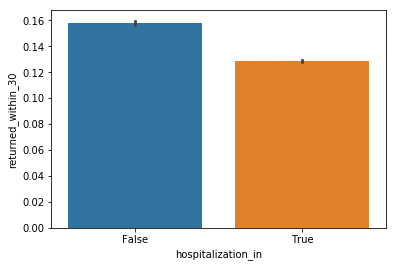

In [12]:
%matplotlib inline
import seaborn as sns
sns.barplot(x=data_no_homeless.hospitalization_in.isnull(), y=data_no_homeless.returned_within_30)

We plot the chance of return as a function of the hospitalization time

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


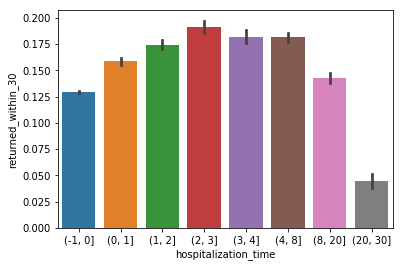

In [13]:
import pandas as pd
data_no_homeless['hospitalization_time'] = (data_no_homeless.hospitalization_out - data_no_homeless.hospitalization_in).fillna(0)
hosp_time_buckets = pd.cut(data_no_homeless.hospitalization_time.apply(lambda x : x.days),bins=[-1,0,1,2,3,4,8,20,30])
sns.barplot(x=hosp_time_buckets, y=data_no_homeless.returned_within_30)

We focus on only the not hospitalized patients, from the general ER

In [14]:
data_no_hospitalization = data_no_homeless[data_no_homeless.hospitalization_in.isnull()]
data_general_miun = data_no_hospitalization[data_no_hospitalization.emergency_wing.isin(['מיון ראשי','מלר"ד ראשי'])].copy()


In [24]:
cnts = data_general_miun.groupby(["id_coded", "admission_date_min"]).size().reset_index()
cnts[cnts[0] > 1]

,id_coded,admission_date_min,0
33034,2.915331e+07,2017-02-21 18:01:00,2
50540,5.082787e+07,2013-02-01 11:25:00,2
75234,7.658438e+07,2013-06-10 09:24:00,2
77244,7.910371e+07,2013-01-10 22:08:00,2
92624,9.055457e+07,2013-05-21 11:06:00,2
143421,1.307948e+08,2013-11-30 15:37:00,2
146071,1.385463e+08,2016-10-17 10:57:00,2
152093,1.505771e+08,2014-12-08 20:40:00,2
177369,1.651917e+08,2013-01-02 15:50:00,2
181103,1.672364e+08,2016-04-24 14:04:00,2


In [15]:
len(data_general_miun)

366398

Lets try to model this

In [19]:
data_general_miun.wing_part_description.value_counts()

רפואה דחופה פנימית      230491
רפואה דחופה מהלכים      124237
פסיכיאטריה                9813
רפואה דחופה טראומה        1845
רפואה דחופה א.א.ג וכ        12
Name: wing_part_description, dtype: int64

Wing part

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_general_miun['wing'] = le.fit_transform(data_general_miun.wing_part_description.fillna(''))

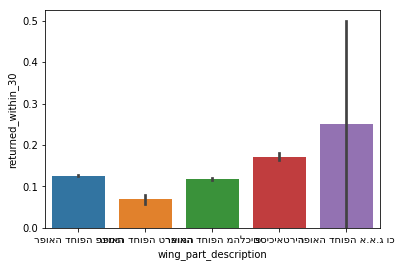

In [21]:
sns.barplot(x=data_general_miun.wing_part_description, y=data_general_miun.returned_within_30)

ESI

In [22]:
import numpy as np
es_mn = data_general_miun[data_general_miun.esi_chameleon != 'UNKNOWN'].esi_chameleon.mean()
data_general_miun['esi_chameleon_enc'] = np.where(data_general_miun.esi_chameleon == 'UNKNOWN',es_mn,data_general_miun.esi_chameleon)

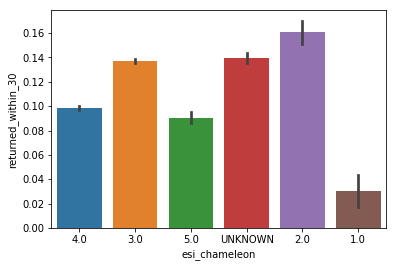

In [23]:
sns.barplot(x=data_general_miun.esi_chameleon, y=data_general_miun.returned_within_30)

Gender

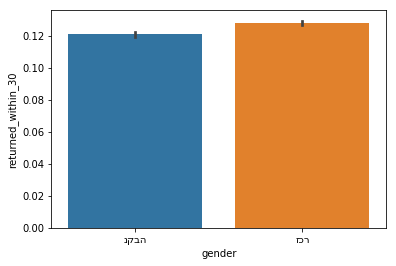

In [24]:
sns.barplot(x=data_general_miun.gender, y=data_general_miun.returned_within_30)

Fever

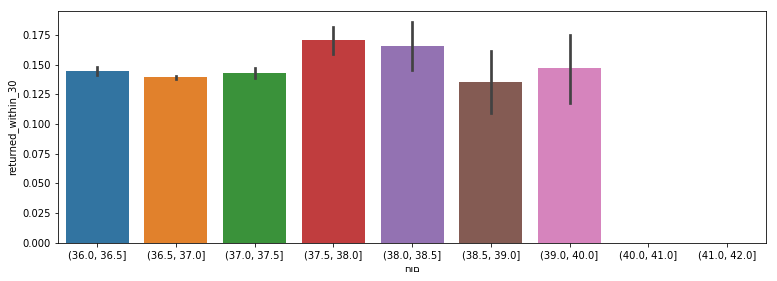

In [26]:
from matplotlib import pyplot
data_general_miun['fever'] = pd.qcut(data_general_miun['חום'],6).apply(lambda x: x.left).astype(float).fillna(10)
nm = 'חום'
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.cut(data_general_miun[nm],bins = [36,36.5,37,37.5,38,38.5,39,40,41,42]), y=data_general_miun.returned_within_30,ax=ax)


Pain

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.


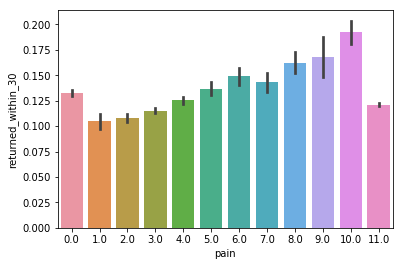

In [27]:
pain = np.floor(np.minimum(10,data_general_miun['כאב']))
data_general_miun['pain'] = pain.fillna(11)
sns.barplot(x=data_general_miun['pain'], y=data_general_miun.returned_within_30)

Inflamatory

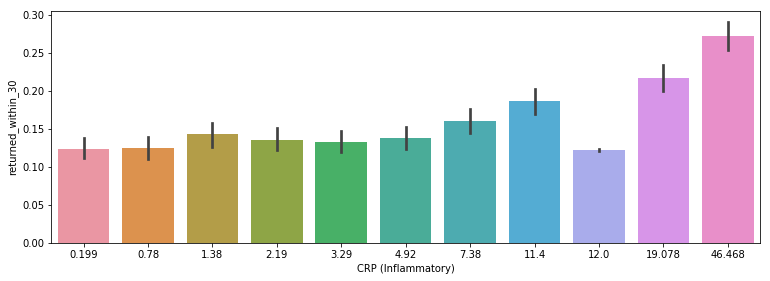

In [28]:
infl = pd.qcut(pd.to_numeric(data_general_miun['CRP (Inflammatory)'], errors='coerce'),10)
infl2 = infl.apply(lambda x: x.left).astype(float).fillna(12)
data_general_miun['infl'] = infl2

fig, ax = pyplot.subplots(figsize=(12.7, 4.27))

sns.barplot(x=infl2, y=data_general_miun.returned_within_30,ax=ax)

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline



ohe = OneHotEncoder(categorical_features=[0,1,2,3])
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
model = Pipeline([('ohe', ohe), ('clf', clf)])
cross_val_score(model,data_general_miun[['wing','esi_chameleon_enc','pain','fever']],y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')


array([0.58239299, 0.58243719, 0.57159065])

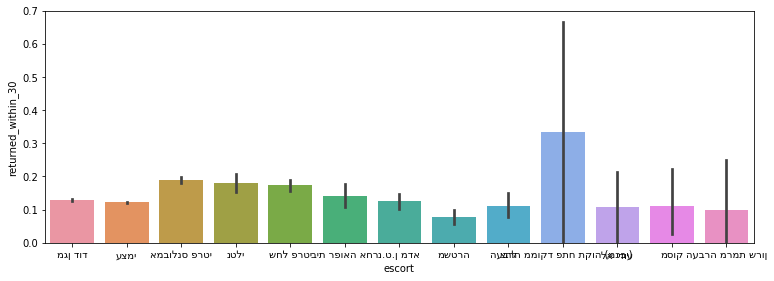

In [32]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
le = LabelEncoder()
data_general_miun['escort_enc'] = le.fit_transform(data_general_miun.escort.astype(str))
sns.barplot(x=data_general_miun.escort, y=data_general_miun.returned_within_30,ax=ax)


In [33]:
import matplotlib as plt
def plot_corr(x,y='returned_within_30',df=None, top =15, title ='', sort = True, orient="v"):
    if sort:
        sortby = y
    else:
        sortby = x

    groups = df.groupby(x, as_index= False)[[y]].mean().sort_values(sortby, ascending = False)
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    sns.barplot(x=x, y=y, data=df, order=groups[x].head(top),ax=ax, orient=orient)
    if len(title) <1:
        title = x +' correlation with ' + y
    plt.title(title,fontsize=24)
    display(groups.head(top)) 

In [66]:
#plot_corr('escort',df =data_general_miun,sort=False )

In [34]:
ohe = OneHotEncoder(categorical_features=[0,1,2,3,4])
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
model = Pipeline([('ohe', ohe), ('clf', clf)])
cross_val_score(model,data_general_miun[['wing','esi_chameleon_enc','pain','fever','escort_enc']],y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')


array([0.58094478, 0.58086257, 0.56776904])

#### ER visit history

In [35]:
data_general_miun['num_total_prev_visits'] = data_general_miun[['patient_admission_dates','admission_date_min']].apply(lambda x:len([y for y in x[0] if y<x[1]]),axis=1)
data_general_miun['num_prev_visits_60days'] = data_general_miun[['patient_admission_dates','admission_date_min']].apply(lambda x:len([y for y in x[0] if y<x[1] and (x[1]-y).days > 60]),axis=1)


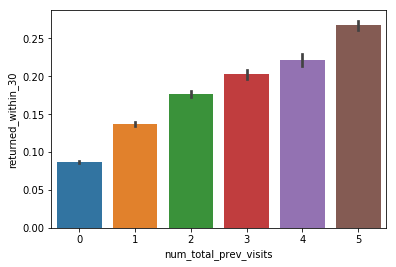

In [36]:
sns.barplot(x=np.minimum(5,data_general_miun['num_total_prev_visits']), y=data_general_miun.returned_within_30)


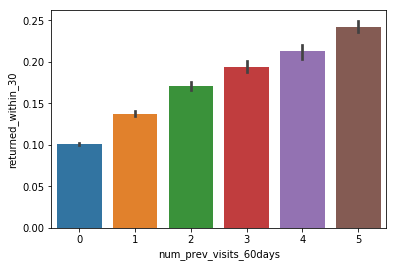

In [37]:
sns.barplot(x=np.minimum(5,data_general_miun['num_prev_visits_60days']), y=data_general_miun.returned_within_30)


Age

In [70]:
data_general_miun['age_enc'] = pd.cut(data_general_miun.age_on_date, bins = [0,18,40,65,110],labels=range(5-1)).fillna(0)

Modeling

In [73]:
ohe = OneHotEncoder(categorical_features=[0,1,2,3,4])
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
model = Pipeline([('ohe', ohe), ('clf', clf)])
cross_val_score(model,data_general_miun[['wing','esi_chameleon_enc','pain','fever','escort_enc','num_total_prev_visits']],y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')


array([0.62329627, 0.62163721, 0.61391093])

In [39]:
def get_feature_dict(emer_diag,back_diag,alergies,sensitivity,main_cause):
    dict = {}
    for a in emer_diag:
        dict['e'+str(a)] = 1
    for a in back_diag:
        dict['b'+str(a)] = 1
    for a in alergies:
        dict['al'+str(a)] = 1
    for a in sensitivity:
        dict['s'+str(a)] = 1
    dict['mc'+str(main_cause)] =1 
    #for a in back_diag:
    #    dict['mc'+str(main_cause)+ str(a)] =1
    #    for b in back_diag:
    #        if a < b:
    #            dict['b'+str(a) + 'b'+str(b)] = 1
    #for a in emer_diag:
    #    for b in emer_diag:
    #        if a < b:
    #            dict['e'+str(a) + 'e'+str(b)] = 1
    #for a in emer_diag:
    #    for b in alergies:
    #        dict['e'+str(a) + 'al'+str(b)] = 1
    return dict

In [40]:
#diag_text = data_general_miun[['diagnoses_in_emergency'].apply(lambda x: {y:1 for y in x})
#diag_text2 = data_general_miun['background_diagnoses'].apply(lambda x: {y:1 for y in x})
diag_text3 = data_general_miun[['background_diagnoses','diagnoses_in_emergency','allergy','sensitivity','main_cause']].apply(lambda x:get_feature_dict(x[1],x[0],x[2],x[3],x[4]),axis=1)
                              
                              
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer()
clf = LogisticRegression()
#clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

model = Pipeline([('dv', dv), ('clf', clf)])
cross_val_score(model,diag_text3,y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')


array([0.63520545, 0.6341229 , 0.62947007])

In [64]:
blood_columns = [col for col in data_general_miun.columns.tolist() if col[0].isupper()]
heb_columns = ['דופק',
 'חום',
 'כאב',
 'לחץ דיאסטולי',
 'לחץ סיסטולי',
 'מספר נשימות',
 'סטורציה',
'סטורציה באויר חדר']

data_numeric = data_general_miun[blood_columns+heb_columns].copy()
convert_to_numeric(data_numeric,numeric_cols = blood_columns+heb_columns)
len(data_general_miun),len(data_numeric)

converting numeric columns to numeric...


(366398, 366398)

In [65]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
imp = Imputer()
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
#clf = XGBClassifier()

model = Pipeline([('imp', imp), ('clf', clf)])
cross_val_score(model,data_numeric,y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')


array([0.62909057, 0.63241034, 0.61383262])

In [50]:
# Sebastian Raschka 2014-2018
# mlxtend Machine Learning Library Extensions
#
# Object for selecting a dataset column in scikit-learn pipelines.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause


from sklearn.base import BaseEstimator
import numpy as np


class ColumnSelector(BaseEstimator):
    """Object for selecting specific columns from a data set.
    Parameters
    ----------
    cols : array-like (default: None)
        A list specifying the feature indices to be selected. For example,
        [1, 4, 5] to select the 2nd, 5th, and 6th feature columns.
        If None, returns all columns in the array.
    drop_axis : bool (default=False)
        Drops last axis if True and the only one column is selected. This
        is useful, e.g., when the ColumnSelector is used for selecting
        only one column and the resulting array should be fed to e.g.,
        a scikit-learn column selector. E.g., instead of returning an
        array with shape (n_samples, 1), drop_axis=True will return an
        aray with shape (n_samples,).
    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/feature_selection/ColumnSelector/
    """

    def __init__(self, cols=None, drop_axis=False):
        self.cols = cols
        self.drop_axis = drop_axis

    def fit_transform(self, X, y=None):
        """ Return a slice of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_slice : shape = [n_samples, k_features]
            Subset of the feature space where k_features <= n_features
        """
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        """ Return a slice of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_slice : shape = [n_samples, k_features]
            Subset of the feature space where k_features <= n_features
        """

        # We use the loc accessor if the input is a pandas dataframe
        if hasattr(X, 'loc'):
            t = X.loc[:, self.cols].values
            return t
            #t = X.loc[:, self.cols]
        else:
            print('b')
            t = X[:, self.cols]

        if t.shape[-1] == 1 and self.drop_axis:
            t = t.reshape(-1)
        if len(t.shape) == 1 and not self.drop_axis:
            t = t[:, np.newaxis]
        return t

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        return self

In [77]:
data_with_good_numeric = convert_to_numeric(data_general_miun,numeric_cols=blood_columns+heb_columns)


converting numeric columns to numeric...


In [78]:
data_general_miun['dict_features'] = diag_text3
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier


def select_first(X):
    return X[['wing','esi_chameleon_enc','pain','fever','escort_enc','num_total_prev_visits']]
def select_second(X):
    return X[['dict_features']]

ft1 = ColumnSelector(['wing','esi_chameleon_enc','pain','fever','escort_enc','num_total_prev_visits'])
ohe = OneHotEncoder(categorical_features=[0,1,2,3,4])
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
pipe1 = Pipeline([('ft1',ft1),('ohe', ohe), ('clf1', rf)])

ft2 = ColumnSelector('dict_features')
dv = DictVectorizer()
lg = LogisticRegression()
pipe2 = Pipeline([('ft2',ft2),('dv', dv), ('clf2', lg)])

ft3 = ColumnSelector(blood_columns+heb_columns)
imp = Imputer()
rf2 = RandomForestClassifier(n_estimators=100,n_jobs=-1)
pipe3 = Pipeline([('ft3',ft3),('imp', imp), ('clf', rf2)])

eclf = VotingClassifier(estimators=[('lg', pipe2), ('rf', pipe1), ('blood' , pipe3)], voting='soft')

#cross_val_score(eclf,data_general_miun[['wing','esi_chameleon_enc','pain','fever','escort_enc','num_total_prev_visits','dict_features']+ blood_columns],y=data_general_miun.returned_within_30,cv=3,scoring='roc_auc')
cross_val_score(eclf,data_with_good_numeric[['wing','esi_chameleon_enc','pain','fever','escort_enc','num_total_prev_visits','dict_features']+ blood_columns+heb_columns],y=data_with_good_numeric.returned_within_30,cv=3,scoring='roc_auc')




array([0.67496663, 0.67879397, 0.66838188])

In [ ]:
def add_death_columns(frame):

   frame.death_date = pd.DatetimeIndex(frame.death_date)

   # Was this person hospitalized
   frame["is_hospitalization"] = ~frame.hospitalization_in.isna()

   frame["T_is_dead"] = ~frame.death_date.isna()

   # The real discharge date
   frame["T_release_date"] = frame["discharge_date_max hospitalization_out".split()].max(axis=1)

   # Total time = ER + hospitalization
   frame["T_total_time_hospital"] = frame.T_release_date - frame.admission_date_min

   # Mortality of the ER
   frame["T_mortality_ER"] = frame.discharge_date_max >= frame.death_date

   # Mortality during hospitalization
   frame["T_mortality_hospitalization"] = (frame.T_release_date >= frame.death_date) & ~frame.T_mortality_ER

   # Mortality after hospitalization
   frame["T_mortality_after_hospitalization"] = frame.death_date > frame.T_release_date

   #
   frame["T_mortality2d"] = frame.death_date <= frame.T_release_date + pd.Timedelta('2d')
   frame["T_mortality30d"] = frame.death_date <= frame.T_release_date + pd.Timedelta('30d')
   frame["T_mortality60d"] = frame.death_date <= frame.T_release_date + pd.Timedelta('60d')


   #
   # frame["T_is_last_hospitalization"] = frame.apply(lambda row: row.admission_date_min == frame[frame.id_coded == row.id_coded].admission_date_min.max() ,axis=1)

   frame["T_mortality_type"] = frame["T_is_dead"]*(frame["T_mortality_ER"] + 2*frame["T_mortality_hospitalization"] + 3*frame["T_mortality_after_hospitalization"])

   return frame
add_death_columns(data_general_miun)

In [62]:
data_general_miun.auxiliary_test_name

CT מוח ללא חומר ניגוד                         28541
CT מוח כולל עצמות פנים ללא ח"נ                 1927
CT עמוד שדרה צוארי, ללא חומר ניגוד             1431
CT בטן אגן עם שתיה,ללא ועם ח"נ                 1099
CT פרוטוקול אבנים ללא חומר ניגוד               1099
CT בטן אגן עם שתיה,עם ח"נ                       960
CT STROKE מוח ללא חומר ניגוד לבירור             926
CT עמוד שדרה מותני, ללא חומר ניגוד              860
CTA עורקי הריאה (PE)                            673
CT מוח כולל ארובות ללא ח"נ                      424
CT ברך ללא חומר ניגוד                           306
CT עצמות האגן ללא חומר ניגוד                    295
CT כתף ללא חומר ניגוד                           258
CT חזה בטן אגן ללא שתיה ,ללא ועם ח"נ            255
CT רקמות רכות בצואר, ללא חומר ניגוד             250
 CTA עורקי צוואר ומוח                           249
CTAV ורידי הראש                                 220
CT בטן אגן ללא שתיה, ללא ועם ח"נ                177
CT בטן אגן ללא שתיה וללא ח"נ                    152
CT כף רגל\אצ

In [92]:
data_general_miun.columns.tolist()

['Albumin -Blood',
 'Alkaline phosphatase -Blood',
 'Amylase -Blood',
 'Bilirubin -Blood, total',
 'CK-MB%',
 'CPK -Blood ,total',
 'CPK-MB',
 'CRP (Inflammatory)',
 'Calcium -Blood, total',
 'Chloride -Blood',
 'Cholesterol, total',
 'Creatinine -Blood',
 'EOS abs.',
 'Gamma GT -Blood',
 'Glucose -Blood',
 'HCO3',
 'HDL-Cholesterol, direct',
 'HGB',
 'HbA1C %',
 'INR',
 'LDH -Blood',
 'LDL Cholesterol, direct',
 'LYMPHO abs.',
 'Lactate',
 'Lipase, pancreatic',
 'MCV',
 'NEUTRO abs.',
 'Osmolality (calc.)',
 'PCO2',
 'PH',
 'PLT',
 'PO2',
 'PT',
 'PTT',
 'Phosphorus -Blood',
 'Potassium -Blood',
 'Protein -Blood, total',
 'SGOT (AST) -Blood',
 'SGPT (ALT) -Blood',
 'Sodium -Blood',
 'T3, free',
 'T4, free',
 'TSH',
 'Triglycerides',
 'Troponin-I',
 'Urea -Blood',
 'WBC',
 'admission_date_chameleon',
 'admission_date_min',
 'age_on_date',
 'allergy',
 'auxiliary_test_date',
 'auxiliary_test_name',
 'background_diagnoses',
 'birth_date',
 'days_in_hospital',
 'death_date',
 'diagnoses_i

### Albumin -Blood

In [95]:
data_general_miun['Albumin -Blood']
sum(~data_general_miun['Albumin -Blood'].isnull())

62064

In [138]:
d2 = data_general_miun[['Albumin -Blood','returned_within_30']].replace('<1.5',1.5).dropna()
print(len(d2))
d2.sample(5)
d2[d2['Albumin -Blood'] == '<1.5']

62064


,Albumin -Blood,returned_within_30


In [141]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true = d2.returned_within_30, y_score=d2['Albumin -Blood'].astype(float))

0.3808425397304291

In [206]:
roc_auc_score(y_true = ~d2.returned_within_30, y_score=d2['Albumin -Blood'].astype(float))

0.619157460269571

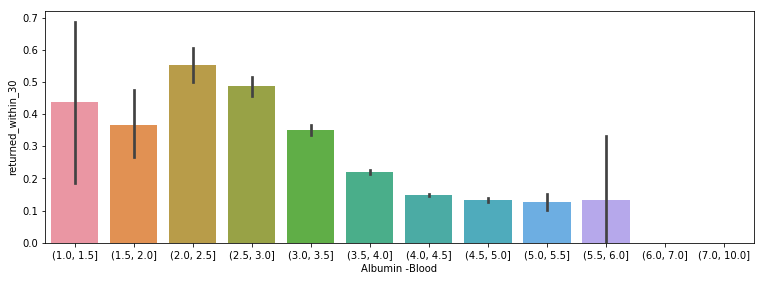

In [147]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.cut(d2['Albumin -Blood'].astype(float),bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,7,10]), y=d2.returned_within_30,ax=ax)

### WBC

In [148]:
sum(~data_general_miun['WBC'].isnull())

203239

In [198]:
data_general_miun.WBC.filter(lambda x: type(x) ==str)

203239

In [200]:
data_general_miun[['WBC','returned_within_30']]
d3= data_general_miun[~pd.to_numeric(data_general_miun.WBC,errors = 'coerse').isnull()][['WBC','returned_within_30']].dropna()
max(d3.WBC)

'99.63'

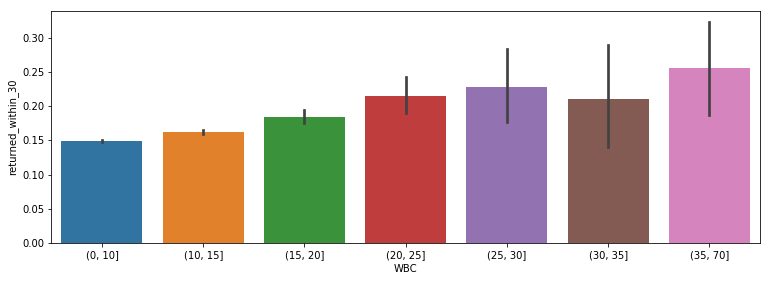

In [205]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.cut(d3['WBC'].astype(float),bins=[0,10,15,20,25,30,35,70]), y=d3.returned_within_30,ax=ax)

In [211]:
roc_auc_score(y_true=d3.returned_within_30,y_score=d3.WBC.astype(float))

0.513121589026709

### HGB

In [207]:
sum(~data_general_miun.HGB.isnull())

203065

In [214]:
d4= data_general_miun[~pd.to_numeric(data_general_miun.HGB,errors = 'coerse').isnull()][['HGB','returned_within_30']].dropna()
max(d4.HGB.astype(float))

22.16

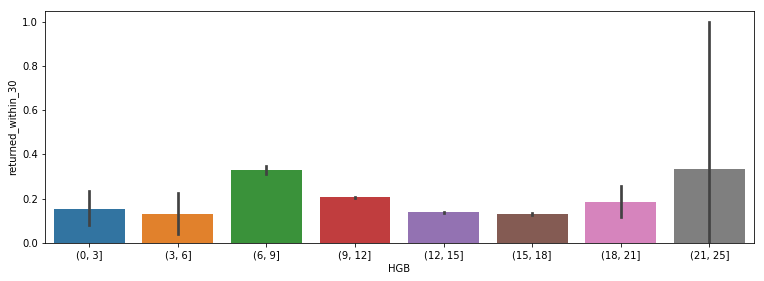

In [215]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.cut(d4['HGB'].astype(float),bins=[0,3,6,9,12,15,18,21,25]), y=d4.returned_within_30,ax=ax)

In [217]:
roc_auc_score(y_true=~d4.returned_within_30,y_score=d4.HGB.astype(float))

0.5661990869598504

In [43]:
def convert_to_numeric(data, numeric_cols = [], ignore_strs=['<','>'],convert_str_map= {}):   
    print('converting numeric columns to numeric...')
    data_numeric= data[numeric_cols].copy()
    for st in ignore_strs:
        data_numeric=data_numeric.applymap(lambda s: s.replace(st,'') if type(s)==str else s)
    for st in convert_str_map.keys():
        data_numeric=data_numeric.applymap(lambda s: s.replace(st,convert_str_map[st]) if type(s)==str else s)
    data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce')
    data[numeric_cols] = data_numeric
    return data

### PLT

In [219]:
d5 = convert_to_numeric(data_general_miun[['PLT','returned_within_30']],numeric_cols=['PLT'])
len(d5)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


365850

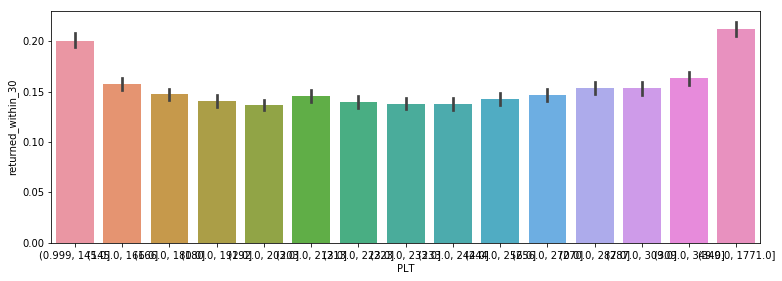

In [224]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.qcut(d5['PLT'].astype(float),15), y=d5.returned_within_30,ax=ax)

### Creatinie

In [235]:
nm = 'Creatinine -Blood'
d6 = convert_to_numeric(data_general_miun[['Creatinine -Blood','returned_within_30']],numeric_cols=['Creatinine -Blood']).dropna()
len(d6)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


202484

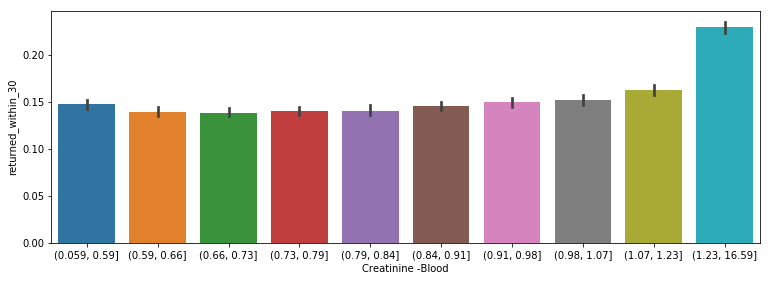

In [236]:
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.qcut(d6[nm].astype(float),10), y=d6.returned_within_30,ax=ax)

In [237]:
roc_auc_score(y_true=d6.returned_within_30,y_score=d6[nm].astype(float))

0.5386018640854137

### UREA

In [266]:
from sklearn.metrics import cohen_kappa_score
def get_auc(col_name):
    d = convert_to_numeric(data_general_miun[[col_name,'returned_within_30']],numeric_cols=[col_name]).dropna()
    auc = roc_auc_score(y_true=d.returned_within_30,y_score=d[col_name].astype(float))
    return max(auc,1-auc)

def get_cohen_kappa(col_name,low,high):
    d = convert_to_numeric(data_general_miun[[col_name,'returned_within_30']],numeric_cols=[col_name]).dropna()
    a = ((d[col_name] < low) | (d[col_name] > high))
    kappa = pearsonr(a,d['returned_within_30'])
    return kappa
    
print(get_auc('Urea -Blood'))
print(get_cohen_kappa('Urea -Blood',15,45))

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0.5473510088948259
converting numeric columns to numeric...
(0.06843045145488925, 8.597612306942319e-209)


In [243]:
data_general_miun.columns.tolist()

['Albumin -Blood',
 'Alkaline phosphatase -Blood',
 'Amylase -Blood',
 'Bilirubin -Blood, total',
 'CK-MB%',
 'CPK -Blood ,total',
 'CPK-MB',
 'CRP (Inflammatory)',
 'Calcium -Blood, total',
 'Chloride -Blood',
 'Cholesterol, total',
 'Creatinine -Blood',
 'EOS abs.',
 'Gamma GT -Blood',
 'Glucose -Blood',
 'HCO3',
 'HDL-Cholesterol, direct',
 'HGB',
 'HbA1C %',
 'INR',
 'LDH -Blood',
 'LDL Cholesterol, direct',
 'LYMPHO abs.',
 'Lactate',
 'Lipase, pancreatic',
 'MCV',
 'NEUTRO abs.',
 'Osmolality (calc.)',
 'PCO2',
 'PH',
 'PLT',
 'PO2',
 'PT',
 'PTT',
 'Phosphorus -Blood',
 'Potassium -Blood',
 'Protein -Blood, total',
 'SGOT (AST) -Blood',
 'SGPT (ALT) -Blood',
 'Sodium -Blood',
 'T3, free',
 'T4, free',
 'TSH',
 'Triglycerides',
 'Troponin-I',
 'Urea -Blood',
 'WBC',
 'admission_date_chameleon',
 'admission_date_min',
 'age_on_date',
 'allergy',
 'auxiliary_test_date',
 'auxiliary_test_name',
 'background_diagnoses',
 'birth_date',
 'days_in_hospital',
 'death_date',
 'diagnoses_i

### LDH

In [268]:
print(get_auc('LDH -Blood'))
print(get_cohen_kappa('LDH -Blood',100,260))

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0.5587190366227334
converting numeric columns to numeric...
(0.0784588160472094, 3.5930778024234623e-150)


### AST

In [269]:
print(get_auc('SGOT (AST) -Blood'))
print(get_cohen_kappa('SGOT (AST) -Blood',7,40))

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0.523002950217619
converting numeric columns to numeric...
(0.056427904721022465, 8.528800336222613e-83)


In [271]:
get_auc('SGPT (ALT) -Blood'), get_cohen_kappa('SGPT (ALT) -Blood',7,45)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...


(0.511294417726488, (0.04250472630241457, 1.0891877450090909e-47))

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


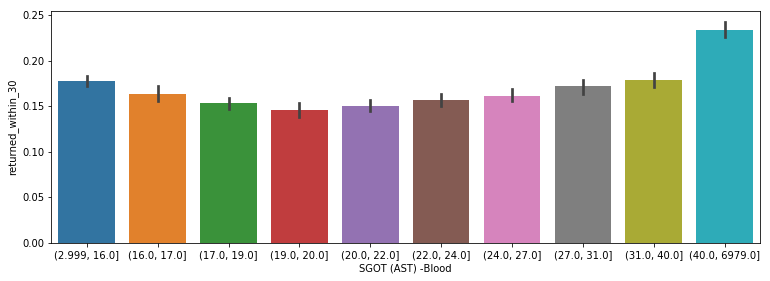

In [248]:
nm = 'SGOT (AST) -Blood'
d7 = convert_to_numeric(data_general_miun[[nm,'returned_within_30']],numeric_cols=[nm]).dropna()
fig, ax = pyplot.subplots(figsize=(12.7, 4.27))
sns.barplot(x=pd.qcut(d7[nm].astype(float),10), y=d7.returned_within_30,ax=ax)

In [272]:
get_auc('Glucose -Blood'), get_cohen_kappa('Glucose -Blood',70,100)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...


(0.5437272296211796, (0.04448386163308941, 2.977895087858797e-89))

In [273]:
get_auc('Sodium -Blood'), get_cohen_kappa('Sodium -Blood',136,148)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...


(0.5465646202410583, (0.0658695682599644, 1.4120727940881934e-193))

In [274]:
get_auc('Potassium -Blood'), get_cohen_kappa('Potassium -Blood',3.5,5.2)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...


(0.5191426079568204, (0.03254923854745837, 1.436637494736644e-48))

In [275]:
get_auc('Phosphorus -Blood'), get_cohen_kappa('Phosphorus -Blood',2,4)

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...


(0.513645042211577, (-0.0026831970135314793, 0.40685711153523707))

In [282]:
blood_columns = [col for col in data_general_miun.columns.tolist() if col[0].isupper()]
blood_columns

['Albumin -Blood',
 'Alkaline phosphatase -Blood',
 'Amylase -Blood',
 'Bilirubin -Blood, total',
 'CK-MB%',
 'CPK -Blood ,total',
 'CPK-MB',
 'CRP (Inflammatory)',
 'Calcium -Blood, total',
 'Chloride -Blood',
 'Cholesterol, total',
 'Creatinine -Blood',
 'EOS abs.',
 'Gamma GT -Blood',
 'Glucose -Blood',
 'HCO3',
 'HDL-Cholesterol, direct',
 'HGB',
 'HbA1C %',
 'INR',
 'LDH -Blood',
 'LDL Cholesterol, direct',
 'LYMPHO abs.',
 'Lactate',
 'Lipase, pancreatic',
 'MCV',
 'NEUTRO abs.',
 'Osmolality (calc.)',
 'PCO2',
 'PH',
 'PLT',
 'PO2',
 'PT',
 'PTT',
 'Phosphorus -Blood',
 'Potassium -Blood',
 'Protein -Blood, total',
 'SGOT (AST) -Blood',
 'SGPT (ALT) -Blood',
 'Sodium -Blood',
 'T3, free',
 'T4, free',
 'TSH',
 'Triglycerides',
 'Troponin-I',
 'Urea -Blood',
 'WBC']

In [283]:
aucs = {col : get_auc(col) for col in blood_columns}

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numeric columns to numeric...
converting numer

In [285]:
sorted(aucs.items(), key=lambda kv: kv[1], reverse=True)

[('T3, free', 0.6289158775737873),
 ('Albumin -Blood', 0.6191574602695709),
 ('T4, free', 0.5945207847990682),
 ('CRP (Inflammatory)', 0.5864152632001873),
 ('Gamma GT -Blood', 0.5822627414573102),
 ('Protein -Blood, total', 0.5820177311229695),
 ('HGB', 0.5661990869598506),
 ('Calcium -Blood, total', 0.5603243893747409),
 ('LDH -Blood', 0.5587190366227334),
 ('LYMPHO abs.', 0.5570929329376186),
 ('Troponin-I', 0.5544949178759229),
 ('Alkaline phosphatase -Blood', 0.5543342396537435),
 ('HbA1C %', 0.5537401129943502),
 ('CPK-MB', 0.5508198816405508),
 ('INR', 0.5488816002730491),
 ('PT', 0.548502599876253),
 ('Chloride -Blood', 0.5478054165620887),
 ('Urea -Blood', 0.5473510088948259),
 ('Sodium -Blood', 0.5465646202410583),
 ('PCO2', 0.5450965521264803),
 ('Glucose -Blood', 0.5437272296211796),
 ('Creatinine -Blood', 0.5386018640854137),
 ('PH', 0.5381424564379567),
 ('CPK -Blood ,total', 0.5375872815781058),
 ('NEUTRO abs.', 0.5307823783938218),
 ('EOS abs.', 0.5275290336177809),
 ('

In [327]:
from statsmodels.discrete.discrete_model import Logit
def get_logit(col_name):
    d = convert_to_numeric(data_general_miun[[col_name,'returned_within_30']],numeric_cols=[col_name]).dropna()
    logit = Logit(d['returned_within_30'], d[col_name])
    result = logit.fit()
    return result.summary().tables[1][1][3].data
    #return np.exp(result.params)[0]
a = get_logit('Albumin -Blood')
a

converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.469681
         Iterations 5


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


' -144.767'

In [326]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
a.summary().tables[1][1][3].data

' -144.767'

In [328]:
odds_ratio = {col : get_logit(col) for col in blood_columns}

converting numeric columns to numeric...


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Optimization terminated successfully.
         Current function value: 0.469681
         Iterations 5
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.523957
         Iterations 6
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.479594
         Iterations 6
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.526135
         Iterations 6
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.586927
         Iterations 6
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.574605
         Iterations 7
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.587201
         Iterations 7
converting numeric columns to numeric...

/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.622078
         Iterations 8
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.490222
         Iterations 6
converting numeric columns to numeric...
Optimization terminated successfully.
         Current function value: 0.473673
         Iterations 6


In [329]:
sorted(odds_ratio.items(), key=lambda kv: kv[1], reverse=True)

[('Sodium -Blood', ' -276.669'),
 ('MCV', ' -275.904'),
 ('HGB', ' -275.897'),
 ('Osmolality (calc.)', ' -275.622'),
 ('Potassium -Blood', ' -273.262'),
 ('PLT', ' -259.677'),
 ('Glucose -Blood', ' -254.436'),
 ('WBC', ' -249.481'),
 ('Creatinine -Blood', ' -247.738'),
 ('LYMPHO abs.', ' -246.223'),
 ('Calcium -Blood, total', ' -243.342'),
 ('NEUTRO abs.', ' -242.764'),
 ('Urea -Blood', ' -236.336'),
 ('Chloride -Blood', ' -232.639'),
 ('EOS abs.', ' -197.797'),
 ('Phosphorus -Blood', ' -177.659'),
 ('LDH -Blood', ' -170.737'),
 ('Alkaline phosphatase -Blood', ' -167.664'),
 ('Amylase -Blood', ' -167.173'),
 ('Bilirubin -Blood, total', ' -162.904'),
 ('SGOT (AST) -Blood', ' -157.078'),
 ('Albumin -Blood', ' -144.767'),
 ('Protein -Blood, total', ' -144.668'),
 ('SGPT (ALT) -Blood', ' -140.002'),
 ('PT', ' -127.281'),
 ('INR', ' -113.581'),
 ('HCO3', ' -113.026'),
 ('Lactate', ' -112.744'),
 ('PO2', '  -99.390'),
 ('CPK -Blood ,total', '  -97.936'),
 ('Troponin-I', '  -79.320'),
 ('PTT'